In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score
import plotly.express as px
import gc

import xgboost as xgb

SEED = 42

In [2]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.isnull().values.any()

False

In [5]:
data.isna().values.any()

False

In [6]:
cat_df = data.select_dtypes(include="object")
cat_df.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,1889.5,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


In [7]:
cat_df.Contract.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [8]:
df = data.copy()

In [9]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [10]:
df.TotalCharges.isnull().value_counts()

False    7032
True       11
Name: TotalCharges, dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.TotalCharges.isnull().value_counts()

False    7032
Name: TotalCharges, dtype: int64

In [13]:
cat_df = df.select_dtypes(include="object")
cat_df.head()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,7590-VHVEG,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,5575-GNVDE,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,3668-QPYBK,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,7795-CFOCW,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,9237-HQITU,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [14]:
num_df = df.select_dtypes(include=["float64","int64"])
num_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,29.85,29.85
1,0,34,56.95,1889.50
2,0,2,53.85,108.15
3,0,45,42.30,1840.75
4,0,2,70.70,151.65


In [15]:
df.drop(columns="customerID", inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

In [17]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}') 

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


In [18]:
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [19]:
df.gender.dtype

dtype('O')

In [20]:
for i in df.columns:
    if df[i].value_counts().shape[0] == 2 and df[i].dtype == 'O':
        df[i].replace({'Yes':1, 'No': 0}, inplace = True)

In [21]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [22]:
df["gender"].replace({"Female": 1, "Male": 0}, inplace=True)

In [23]:
for column in df:
    if df[column].dtypes=='object':
        print(f'{column}: {df[column].unique()}')

InternetService: ['DSL' 'Fiber optic' 'No']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [24]:
df = pd.get_dummies(data = df, columns=['InternetService', "Contract", "PaymentMethod"])

In [25]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [26]:
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No             

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.495307,0.500014,0.00,0.0000,0.000,1.0000,1.00
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
Partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
Dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
PhoneService,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
MultipleLines,7032.0,0.421928,0.493902,0.00,0.0000,0.000,1.0000,1.00
OnlineSecurity,7032.0,0.286547,0.452180,0.00,0.0000,0.000,1.0000,1.00
OnlineBackup,7032.0,0.344852,0.475354,0.00,0.0000,0.000,1.0000,1.00
DeviceProtection,7032.0,0.343857,0.475028,0.00,0.0000,0.000,1.0000,1.00


In [28]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [29]:
df_minmax_scaled = df.copy()

In [30]:
scale_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

scaler = MinMaxScaler()

df_minmax_scaled[scale_cols] = scaler.fit_transform(df_minmax_scaled[scale_cols])

In [31]:
for col in df_minmax_scaled.columns:
    print(f'{col}: {df_minmax_scaled[col].unique()}')

gender: [1 0]
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [0 1]
MultipleLines: [0 1]
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [

In [32]:
X = df_minmax_scaled.drop(columns='Churn')
y = df_minmax_scaled["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [33]:
X_train.shape

(5625, 26)

In [34]:
X_test.shape

(1407, 26)

In [35]:
clf_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate= 0.1,
    subsample=0.8,
    colsample_bytree=0.2,
    random_state = SEED
)
clf_xgb.fit(X_train, y_train)
accuracy_xgb = clf_xgb.score(X_test, y_test)
print(accuracy_xgb)

0.7711442786069652


In [36]:
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=SEED
)
clf_rf.fit(X_train, y_train)
accuracy_rf = clf_rf.score(X_test, y_test)
print(accuracy_rf)

0.7796730632551528


In [54]:
clf_nn = keras.Sequential([
    # input layer
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1,activation = 'sigmoid'),
    # we use sigmoid for binary output
    # output layer
]
)

In [55]:
# time for compilation of neural net.
clf_nn.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
# now we fit our model to training data
clf_nn.fit(X_train, y_train, epochs=100)

Epoch 1/100
176/176 [==============================] - 1s 1ms/step - loss: 0.4962 - accuracy: 0.7540
Epoch 2/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.7943
Epoch 3/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4180 - accuracy: 0.8027
Epoch 4/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4158 - accuracy: 0.8034
Epoch 5/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4117 - accuracy: 0.8043
Epoch 6/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4097 - accuracy: 0.8087
Epoch 7/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4094 - accuracy: 0.8076
Epoch 8/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4073 - accuracy: 0.8062
Epoch 9/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4065 - accuracy: 0.8105
Epoch 10/100
176/176 [==============================] - 0s 1ms/step - loss: 0.4055 - accura

In [57]:
clf_nn.evaluate(X_test, y_test)

44/44 [==============================] - 0s 977us/step - loss: 0.4837 - accuracy: 0.7726


[0.48372700810432434, 0.7725657224655151]

In [40]:
class Ensemble(object):
    
    def __init__(self, k, stacker, base_models):
        
        self.k = k # How many folds used in cross validation
        
        self.stacker = stacker # Final model used for stacking
        
        self.base_models = base_models # Base models in specific layers

    def fit_predict(self, X, y, pred_matrix):
        """
        This function calculates the meta features for each layer.
        """
        X = np.array(X) 
        
        y = np.array(y) 
        
        pred_matrix = np.array(pred_matrix)

        kf = KFold(n_splits=self.k, shuffle=True, random_state=0) # Split the train data into k folds

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        
        S_test = np.zeros((pred_matrix.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models): # Iterate through the base models in a layer
            S_test_i = np.zeros((pred_matrix.shape[0], self.k))

            for j, (train_idx, test_idx) in enumerate(kf.split(X)):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                clf.fit(X_train, y_train) # Fit the specific base model
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(pred_matrix)[:]

            S_test[:, i] = S_test_i.mean(1)
            
        self.stacker.fit(S_train, y)
        
        y_pred = self.stacker.predict(S_test)[:]
    
        return S_train, y_pred, S_test
    
    def layer_pred(self, num_layer, X_input, Y_input, base_models, models, pred_matrix, endmodel):
        """
        This function reads in the train and test data, iterates through the layers,
        and outputs the predictions.
        """
        # level 1:
        S_train, y_pred, S_test = self.fit_predict(X_input, Y_input, pred_matrix)
        # level num_layer:
        ##BEGIN iteration##
        for index in range(0,num_layer):
            
            self.base_models = models[index] 

            S_train, y_pred, S_test = self.fit_predict(S_train, Y_input, S_test)
            
        ##END iteration##
        
        endmodel.fit(S_train, Y_input)
        
        y_pred = endmodel.predict(S_test)[:]
        
        return y_pred

In [41]:
level1 = [neural_network.MLPClassifier(hidden_layer_sizes=(1000, 15), random_state = SEED, max_iter = 500),ensemble.RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED), xgb.XGBClassifier(n_estimators=40, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7, random_state = SEED)]
# Second level regressors
level2 = [xgb.XGBClassifier(), linear_model.LogisticRegression()]

In [42]:
models = {0: level2}

In [43]:
fitter_three = Ensemble(10, xgb.XGBClassifier(), level1)
#y_stack1_fitter_three = fitter_three.layer_pred(1, x1, y1, level1, models, x2, xgb.XGBRegressor()) -------x2 = x_test

In [44]:
y_stack1_fitter_three = fitter_three.layer_pred(1, X_train, y_train, level1, models, X_test, xgb.XGBClassifier()) 

In [49]:
y_stack1_fitter_three.shape

(1407,)

In [46]:
print(accuracy_score(y_test, y_stack1_fitter_three), precision_score(y_test, y_stack1_fitter_three))

0.7967306325515281 0.6774193548387096


In [50]:
print(accuracy_score(y_test, y_stack1_fitter_three), precision_score(y_test, y_stack1_fitter_three)) #max_iter = 500


0.7967306325515281 0.6774193548387096


In [47]:
# Write the predictions on the test set to a csv
#prediction = pd.DataFrame(y_stack1_fitter_three, columns=['redshift']).to_csv('submission.csv', index_label = 'id')

In [48]:
df_minmax_scaled.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7032, 27), (5625, 26), (5625,), (1407, 26), (1407,))

## To-Do: EDA, feature engineering

In [35]:
fig = px.box(data, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

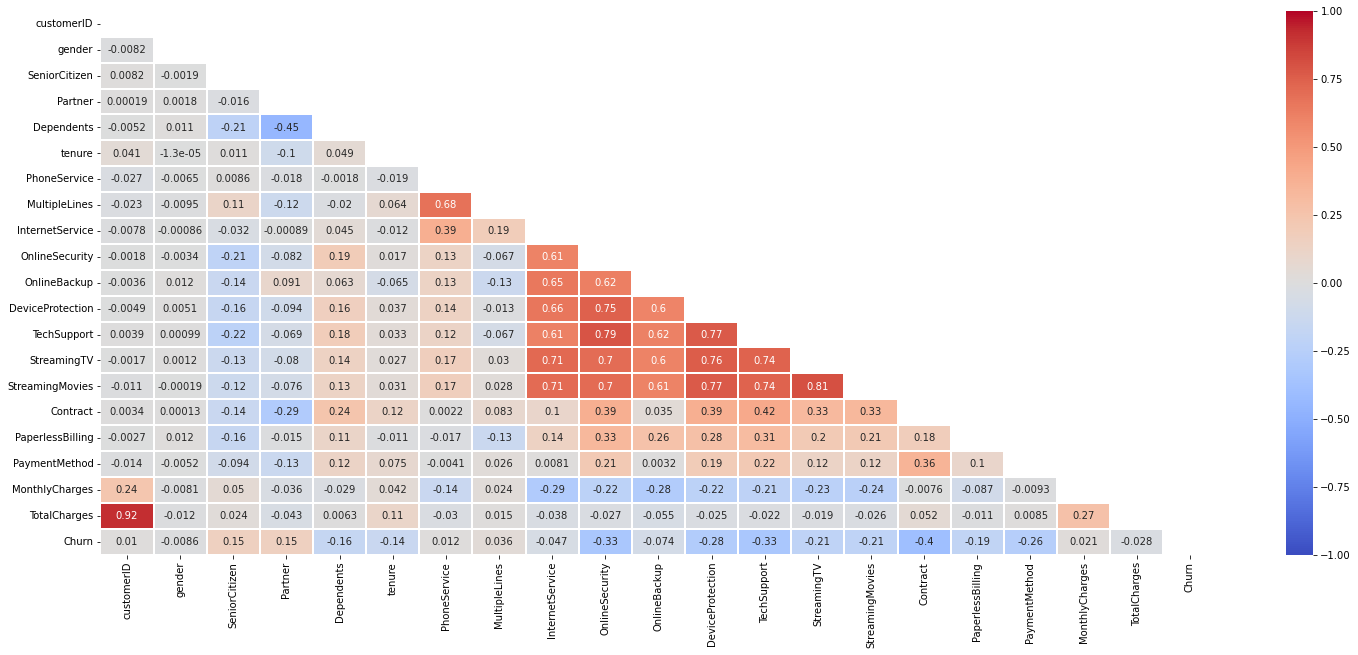

In [36]:
plt.figure(figsize=(25, 10))

corr = data.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)